In [1]:
import numpy as np
import sklearn
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
#import optuna
#from optuna.integration import SklearnSearchCV


In [2]:
# Carga la base de datos desde un archivo csv
df = pd.read_csv('data_limpio.csv')
df

,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,...,repaglinide,glipizide,insulin,count_No,count_Steady,count_Down,count_Up,change,diabetesMed,readmitted
0,1,Emergency,Discharged to home,Referral,1,41,0,1,0,0,...,No,No,No,4,0,0,0,No,No,NO
1,2,Emergency,Discharged to home,Emergency Room,3,59,0,18,0,0,...,No,No,Up,3,0,0,1,Ch,Yes,NO
2,3,Emergency,Discharged to home,Emergency Room,2,11,5,13,2,0,...,No,Steady,No,3,1,0,0,No,Yes,NO
3,4,Emergency,Discharged to home,Emergency Room,2,44,1,16,0,0,...,No,No,Up,3,0,0,1,Ch,Yes,NO
4,5,Emergency,Discharged to home,Emergency Room,1,51,0,8,0,0,...,No,Steady,Steady,2,2,0,0,Ch,Yes,NO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,8,Emergency,Discharged/Transferred,Emergency Room,3,51,0,16,0,0,...,No,No,Down,2,1,1,0,Ch,Yes,NO
101762,9,Emergency,Discharged/Transferred,Transfer,5,33,3,18,0,0,...,No,No,Steady,3,1,0,0,No,Yes,NO
101763,8,Emergency,Discharged to home,Emergency Room,1,53,0,9,1,0,...,No,No,Down,2,1,1,0,Ch,Yes,NO
101764,9,Urgent,Discharged/Transferred,Emergency Room,10,45,2,21,0,0,...,No,Steady,Up,2,1,0,1,Ch,Yes,NO


In [3]:
# Muestra los valores unicos de la columna que sera el target
valores_unicos = df['readmitted'].unique()
valores_unicos

array(['NO', '<30'], dtype=object)

In [4]:
# Reemplazar 'NO' por 0 y cualquier otro valor por 1
df['readmitted'] = df['readmitted'].replace({'NO': 0, '<30': 1})

# Elimina las columnas raras del dataframe
rare_cols = ['count_No', 'count_Steady', 'count_Up', 'count_Down']
df = df.drop(rare_cols, axis=1)

C:\Users\Guille\AppData\Local\Temp\ipykernel_6384\2617644066.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['readmitted'] = df['readmitted'].replace({'NO': 0, '<30': 1})


readmitted
0    90409
1    11357
Name: count, dtype: int64


<Axes: xlabel='readmitted', ylabel='count'>

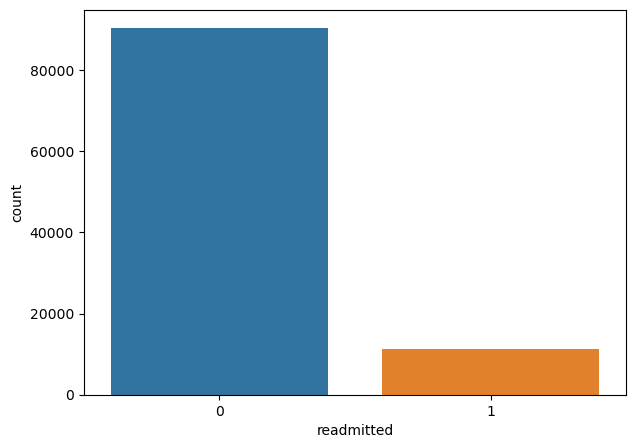

In [5]:
print(df.readmitted.value_counts())
plt.figure(figsize=(7,5))
sns.countplot(x='readmitted', data=df)

In [6]:
df.shape

(101766, 24)

In [7]:
# Selecciona automáticamente las columnas categóricas del DataFrame
categorical_columns = df.select_dtypes(include=['object']).columns

# Realiza codificación one-hot manualmente para cada columna categórica
encoded_columns = pd.get_dummies(df[categorical_columns])

# Convierte las columnas codificadas one-hot en valores numéricos
encoded_columns = encoded_columns.astype(int)

# Concatena las columnas codificadas one-hot con el DataFrame original
df_encoded = pd.concat([df.drop(columns=categorical_columns), encoded_columns], axis=1)

df_encoded

,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,readmitted,...,glipizide_Steady,glipizide_Up,insulin_Down,insulin_No,insulin_Steady,insulin_Up,change_Ch,change_No,diabetesMed_No,diabetesMed_Yes
0,1,1,41,0,1,0,0,0,1,0,...,0,0,0,1,0,0,0,1,1,0
1,2,3,59,0,18,0,0,0,9,0,...,0,0,0,0,0,1,1,0,0,1
2,3,2,11,5,13,2,0,1,6,0,...,1,0,0,1,0,0,0,1,0,1
3,4,2,44,1,16,0,0,0,7,0,...,0,0,0,0,0,1,1,0,0,1
4,5,1,51,0,8,0,0,0,5,0,...,1,0,0,0,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,8,3,51,0,16,0,0,0,9,0,...,0,0,1,0,0,0,1,0,0,1
101762,9,5,33,3,18,0,0,1,9,0,...,0,0,0,0,1,0,0,1,0,1
101763,8,1,53,0,9,1,0,0,13,0,...,0,0,1,0,0,0,1,0,0,1
101764,9,10,45,2,21,0,0,1,9,0,...,1,0,0,0,0,1,1,0,0,1


In [8]:
# Define las features y la variable target
X = df_encoded.drop('readmitted', axis=1)  # Features
y = df_encoded['readmitted']  # Target variable

In [9]:
# Separa los datos de entrenamiento y evaulacion
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

Creacion del modelo

In [10]:
# Funcion que crea el modelo de ML con Keras
def build_model(n_neurons=5,input_shape=(101,)):
  model = keras.models.Sequential()
  model.add(keras.layers.Dense(n_neurons, activation='relu', input_shape=input_shape))
  model.add(keras.layers.Dense(n_neurons, activation='relu' ))
  model.add(keras.layers.Dense(1, activation='sigmoid'))
  model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])
  return model

In [11]:
# Crea un clasificador de Keras que es compatible con scikit-learn
keras_cs = keras.wrappers.scikit_learn.KerasClassifier(build_fn=build_model, epochs=100, validation_split=0.2)

C:\Users\Guille\AppData\Local\Temp\ipykernel_6384\1618677641.py:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_cs = keras.wrappers.scikit_learn.KerasClassifier(build_fn=build_model, epochs=100, validation_split=0.2)


In [12]:
# Crea un pipeline en scikit-learn. Un pipeline es una secuencia de transformaciones y un estimador final. 
model =  Pipeline([
                   ('scale', StandardScaler()), ('ann', keras_cs)
])

In [13]:
# Inicia el entrenamiento del modelo de keras
model.fit(X_train,y_train)

Epoch 1/100
2036/2036 [==============================] - 3s 1ms/step - loss: 0.3866 - accuracy: 0.8790 - val_loss: 0.3427 - val_accuracy: 0.8922
Epoch 2/100
2036/2036 [==============================] - 2s 973us/step - loss: 0.3498 - accuracy: 0.8877 - val_loss: 0.3371 - val_accuracy: 0.8922
Epoch 3/100
2036/2036 [==============================] - 2s 1ms/step - loss: 0.3454 - accuracy: 0.8877 - val_loss: 0.3348 - val_accuracy: 0.8922
Epoch 4/100
2036/2036 [==============================] - 2s 947us/step - loss: 0.3430 - accuracy: 0.8877 - val_loss: 0.3333 - val_accuracy: 0.8922
Epoch 5/100
2036/2036 [==============================] - 2s 942us/step - loss: 0.3412 - accuracy: 0.8877 - val_loss: 0.3322 - val_accuracy: 0.8922
Epoch 6/100
2036/2036 [==============================] - 2s 934us/step - loss: 0.3397 - accuracy: 0.8877 - val_loss: 0.3315 - val_accuracy: 0.8922
Epoch 7/100
2036/2036 [==============================] - 2s 977us/step - loss: 0.3385 - accuracy: 0.8877 - val_loss: 0.330

Pipeline(steps=[('scale', StandardScaler()),
                ('ann',
                 <keras.wrappers.scikit_learn.KerasClassifier object at 0x000001EAE8810340>)])

In [14]:
# Predice según los datos de testeo e imprime los resultados con cuatro decimales
y_fit = model.predict(X_test)
print(classification_report(y_test, y_fit, digits=4))

637/637 [==============================] - 0s 599us/step
              precision    recall  f1-score   support

           0     0.8877    1.0000    0.9405     18069
           1     0.0000    0.0000    0.0000      2285

    accuracy                         0.8877     20354
   macro avg     0.4439    0.5000    0.4703     20354
weighted avg     0.7881    0.8877    0.8349     20354



c:\Users\Guille\anaconda3\envs\Nocountry_proyect_01\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Guille\anaconda3\envs\Nocountry_proyect_01\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Guille\anaconda3\envs\Nocountry_proyect_01\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

In [22]:
# Limpia el modelo anteior para liberar espacio en memoria
keras.backend.clear_session()

### Se procedera a buscar los mejores hiperparametros para el modelo

In [23]:
# Esta funcion crea un modelo de keras con hiperparametro especificos
def build_model(n_hidden=1, n_neurons=5,input_shape=(101,)):
  model = keras.models.Sequential()
  model.add(keras.layers.Dense(n_neurons, activation='relu', input_shape=input_shape))
  for i in range(n_hidden):
    model.add(keras.layers.Dense(n_neurons, activation='relu'))
  model.add(keras.layers.Dense(1, activation='sigmoid'))
  model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])
  return model

In [24]:
keras_cs = keras.wrappers.scikit_learn.KerasClassifier(build_fn=build_model, epochs=50, verbose=0)

C:\Users\Guille\AppData\Local\Temp\ipykernel_6384\854310640.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_cs = keras.wrappers.scikit_learn.KerasClassifier(build_fn=build_model, epochs=50, verbose=0)


In [25]:
model =  Pipeline([
                   ('scale', StandardScaler()), ('ann', keras_cs)
])

In [26]:
# Diccionario con los hiperparametros a testear
params = {
    'ann__n_hidden':[0,1,2,3],
    'ann__n_neurons':np.arange(0,15),
    'ann__batch_size':[10,15,20]
}

In [27]:
rnd_search = RandomizedSearchCV(model, params, n_iter=10, cv=3, n_jobs=-1, verbose=2)

In [28]:
grid_result = rnd_search.fit(X_train,y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


In [29]:
grid_result.best_params_

{'ann__n_neurons': 9, 'ann__n_hidden': 1, 'ann__batch_size': 20}

In [30]:
sk_params = {
    'batch_size':grid_result.best_params_['ann__batch_size'],
    'n_hidden': grid_result.best_params_['ann__n_hidden'],
    'n_neurons':grid_result.best_params_['ann__n_neurons']
}

In [31]:
sk_params

{'batch_size': 20, 'n_hidden': 1, 'n_neurons': 9}

In [40]:
keras.backend.clear_session()

In [41]:
keras_cs = keras.wrappers.scikit_learn.KerasClassifier(build_fn=build_model, epochs=20, verbose=1, **sk_params )

C:\Users\Guille\AppData\Local\Temp\ipykernel_6384\2354317905.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_cs = keras.wrappers.scikit_learn.KerasClassifier(build_fn=build_model, epochs=20, verbose=1, **sk_params )


In [42]:
model =  Pipeline([
                   ('scale', StandardScaler()), ('ann', keras_cs)
])

In [43]:
model.fit(X_train,y_train)

Epoch 1/20
4071/4071 [==============================] - 4s 800us/step - loss: 0.3552 - accuracy: 0.8881
Epoch 2/20
4071/4071 [==============================] - 3s 829us/step - loss: 0.3390 - accuracy: 0.8886
Epoch 3/20
4071/4071 [==============================] - 3s 799us/step - loss: 0.3360 - accuracy: 0.8886
Epoch 4/20
4071/4071 [==============================] - 3s 812us/step - loss: 0.3344 - accuracy: 0.8886
Epoch 5/20
4071/4071 [==============================] - 3s 825us/step - loss: 0.3331 - accuracy: 0.8886
Epoch 6/20
4071/4071 [==============================] - 3s 844us/step - loss: 0.3323 - accuracy: 0.8886
Epoch 7/20
4071/4071 [==============================] - 3s 842us/step - loss: 0.3315 - accuracy: 0.8887
Epoch 8/20
4071/4071 [==============================] - 3s 789us/step - loss: 0.3310 - accuracy: 0.8887
Epoch 9/20
4071/4071 [==============================] - 3s 798us/step - loss: 0.3305 - accuracy: 0.8888
Epoch 10/20
4071/4071 [==============================] - 3s 791u

Pipeline(steps=[('scale', StandardScaler()),
                ('ann',
                 <keras.wrappers.scikit_learn.KerasClassifier object at 0x000001EA83CB42E0>)])

637/637 [==============================] - 0s 590us/step
              precision    recall  f1-score   support

           0     0.8884    0.9992    0.9405     18069
           1     0.5312    0.0074    0.0147      2285

    accuracy                         0.8878     20354
   macro avg     0.7098    0.5033    0.4776     20354
weighted avg     0.8483    0.8878    0.8366     20354



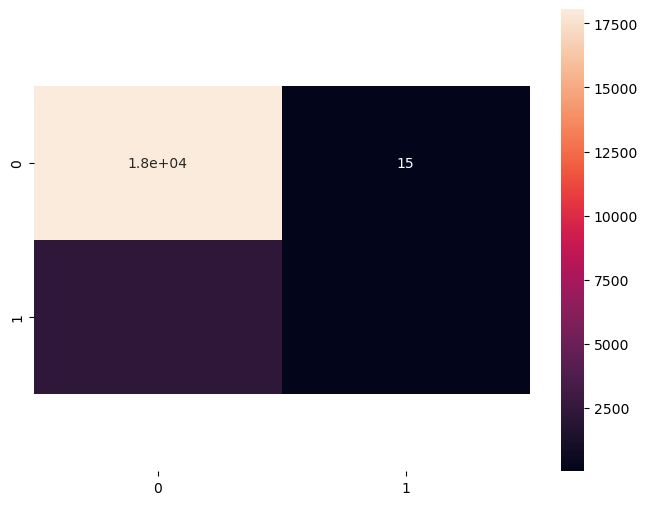

In [44]:
y_fit = model.predict(X_test)

plt.figure(figsize=(8, 6))
conf_matrix = confusion_matrix(y_test, y_fit)
sns.heatmap(conf_matrix, annot=True)  # Utiliza fmt=".4f" para imprimir números con 4 decimales
b, t = plt.ylim() 
b += 0.5 
t -= 0.5 
plt.ylim(b, t)

# Imprimir el informe de clasificación con números con 4 decimales
print(classification_report(y_test, y_fit, digits=4))


***

In [4]:
import pandas as pd

In [5]:
# Carga la base de datos desde un archivo csv
df = pd.read_csv('diabetic_data.csv')
df

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,443847548,100162476,AfricanAmerican,Male,[70-80),?,1,3,7,3,...,No,Down,No,No,No,No,No,Ch,Yes,>30
101762,443847782,74694222,AfricanAmerican,Female,[80-90),?,1,4,5,5,...,No,Steady,No,No,No,No,No,No,Yes,NO
101763,443854148,41088789,Caucasian,Male,[70-80),?,1,1,7,1,...,No,Down,No,No,No,No,No,Ch,Yes,NO
101764,443857166,31693671,Caucasian,Female,[80-90),?,2,3,7,10,...,No,Up,No,No,No,No,No,Ch,Yes,NO


In [21]:
# Muestra los valores únicos del dataframe
for column in df.columns:
    valores_unicos = df[column].unique()
    print(f'{column} valores únicos: {valores_unicos}')

encounter_id valores únicos: [  2278392    149190     64410 ... 443854148 443857166 443867222]
patient_nbr valores únicos: [  8222157  55629189  86047875 ... 140199494 120975314 175429310]
race valores únicos: ['Caucasian' 'AfricanAmerican' nan 'Other' 'Asian' 'Hispanic']
gender valores únicos: ['Female' 'Male' 'Unknown/Invalid']
age valores únicos: ['[0-10)' '[10-20)' '[20-30)' '[30-40)' '[40-50)' '[50-60)' '[60-70)'
 '[70-80)' '[80-90)' '[90-100)']
weight valores únicos: [nan '[75-100)' '[50-75)' '[0-25)' '[100-125)' '[25-50)' '[125-150)'
 '[175-200)' '[150-175)' '>200']
admission_type_id valores únicos: [6 1 2 3 4 5 8 7]
discharge_disposition_id valores únicos: [25  1  3  6  2  5 11  7 10  4 14 18  8 13 12 16 17 22 23  9 20 15 24 28
 19 27]
admission_source_id valores únicos: [ 1  7  2  4  5  6 20  3 17  8  9 14 10 22 11 25 13]
time_in_hospital valores únicos: [ 1  3  2  4  5 13 12  9  7 10  6 11  8 14]
payer_code valores únicos: [nan 'MC' 'MD' 'HM' 'UN' 'BC' 'SP' 'CP' 'SI' 'DM' 'CM

In [16]:
# Muestra los valores unicos del dataframe
for column in df.columns:
    valores_unicos = df[column].dtype
    valores_unicos
    print(column,' valores: ',valores_unicos)

encounter_id  valores:  int64
patient_nbr  valores:  int64
race  valores:  object
gender  valores:  object
age  valores:  object
weight  valores:  object
admission_type_id  valores:  int64
discharge_disposition_id  valores:  int64
admission_source_id  valores:  int64
time_in_hospital  valores:  int64
payer_code  valores:  object
medical_specialty  valores:  object
num_lab_procedures  valores:  int64
num_procedures  valores:  int64
num_medications  valores:  int64
number_outpatient  valores:  int64
number_emergency  valores:  int64
number_inpatient  valores:  int64
diag_1  valores:  object
diag_2  valores:  object
diag_3  valores:  object
number_diagnoses  valores:  int64
max_glu_serum  valores:  object
A1Cresult  valores:  object
metformin  valores:  object
repaglinide  valores:  object
nateglinide  valores:  object
chlorpropamide  valores:  object
glimepiride  valores:  object
acetohexamide  valores:  object
glipizide  valores:  object
glyburide  valores:  object
tolbutamide  valores:

In [12]:
# Contar la frecuencia de cada valor en la columna
frequencies = df['patient_nbr'].value_counts()

# Filtrar los valores que se repiten (frecuencia > 1)
valores_repetidos = frequencies[frequencies > 1]

valores_repetidos.shape

(16773,)

In [18]:
# Replacing unknown values to NaN
df.replace('?', np.nan, inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      99493 non-null   object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    3197 non-null    object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                61510 non-null   object
 11  medical_specialty         51817 non-null   object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

In [20]:
round((df.isnull().sum() / df.shape[0]) * 100, 2).astype('str') + ' %'

encounter_id                  0.0 %
patient_nbr                   0.0 %
race                         2.23 %
gender                        0.0 %
age                           0.0 %
weight                      96.86 %
admission_type_id             0.0 %
discharge_disposition_id      0.0 %
admission_source_id           0.0 %
time_in_hospital              0.0 %
payer_code                  39.56 %
medical_specialty           49.08 %
num_lab_procedures            0.0 %
num_procedures                0.0 %
num_medications               0.0 %
number_outpatient             0.0 %
number_emergency              0.0 %
number_inpatient              0.0 %
diag_1                       0.02 %
diag_2                       0.35 %
diag_3                        1.4 %
number_diagnoses              0.0 %
max_glu_serum               94.75 %
A1Cresult                   83.28 %
metformin                     0.0 %
repaglinide                   0.0 %
nateglinide                   0.0 %
chlorpropamide              

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import pandas as pd

# Separar características y etiquetas
X = df.drop('readmission', axis=1)
y = df['readmission']

# Codificar etiquetas usando LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# División de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Normalización de características usando StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convertir datos de pandas a tensores de PyTorch
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Definir la arquitectura de la red neuronal
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.softmax(out)
        return out

# Parámetros de la red neuronal
input_size = X_train.shape[1]
hidden_size = 50
num_classes = len(df['readmission'].unique())

# Crear instancia del modelo
model = NeuralNetwork(input_size, hidden_size, num_classes)

# Función de pérdida y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Entrenamiento del modelo
num_epochs = 100
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    # Backward y optimización
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluación del modelo en conjunto de prueba
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs, 1)
    accuracy = (predicted == y_test_tensor).sum().item() / len(y_test_tensor)
    print(f'Accuracy on test set: {accuracy:.4f}')

# Predicción de probabilidades para nuevos datos
new_data = {'feature1': [2.0], 'feature2': [1.0], 'feature3': [25]}
new_df = pd.DataFrame(new_data)
new_data_scaled = scaler.transform(new_df)
new_data_tensor = torch.tensor(new_data_scaled, dtype=torch.float32)
model.eval()
with torch.no_grad():
    probabilities = model(new_data_tensor)
    probabilities = probabilities.numpy().flatten()
    predicted_label = label_encoder.classes_[torch.argmax(probabilities)]
    print(f'Predicted probabilities: {probabilities}')
    print(f'Predicted label: {predicted_label}')
